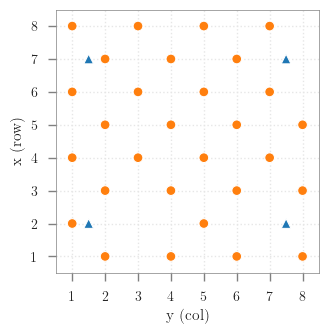

In [1]:
%run rutgers-base.ipynb

## Machine learning approach

In [9]:
from sklearn import metrics, model_selection, tree, linear_model, pipeline, preprocessing, dummy
from imblearn import pipeline as ipipeline, metrics as imetrics, over_sampling, under_sampling

SEED = 0xABCD
features = ['stdRSSI', 'meanRSSI', 'rssi']
labels = ('good', 'interm.', 'bad')


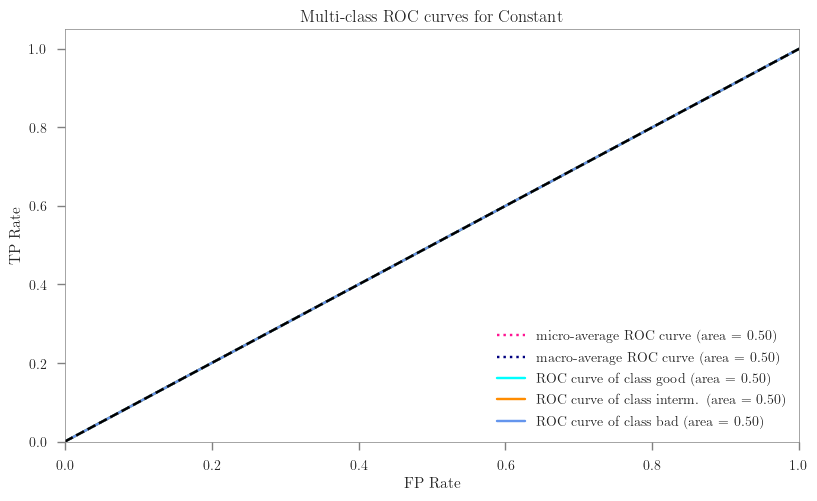

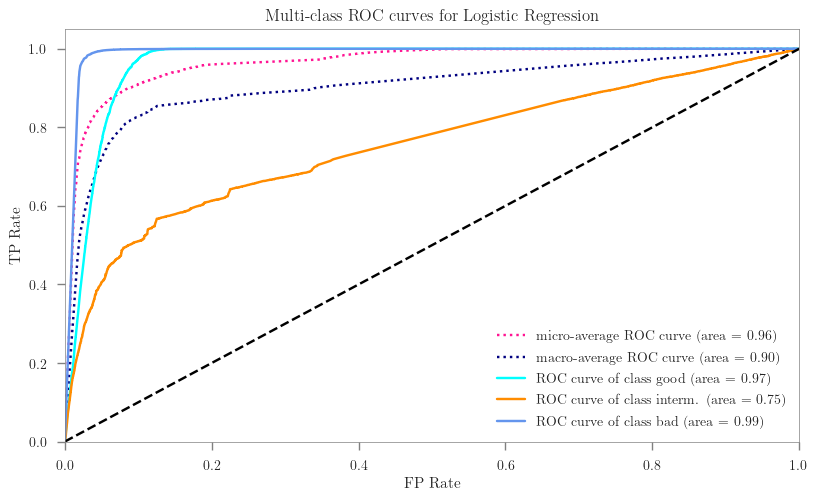

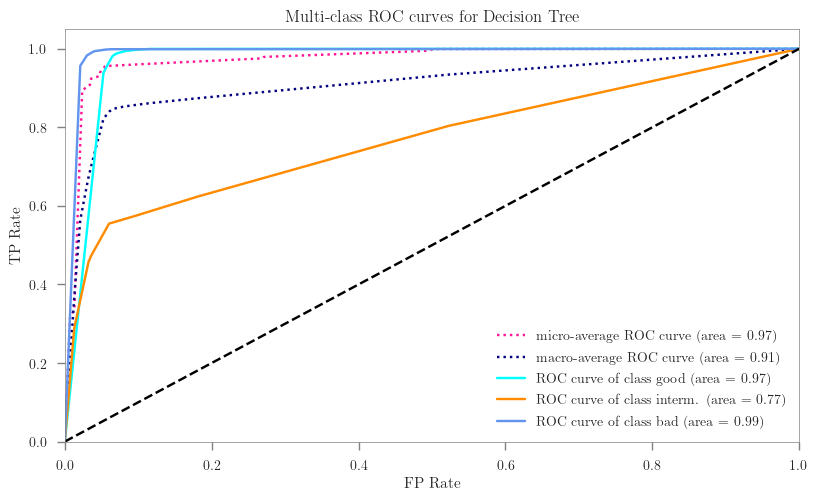

In [17]:
good, interm, bad = labels

def labelify(value: float):
    if value >= 0.9: return good
    if value <= 0.1: return bad
    return interm


def roc_curves():
    from sklearn import multiclass
    from itertools import cycle
    
    latexify(columns=2, scale=1.5)

    baseline = ipipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        over_sampling.RandomOverSampler(random_state=SEED),
        dummy.DummyClassifier(strategy='constant', constant=1, random_state=SEED),
    )

    logreg = ipipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        over_sampling.RandomOverSampler(random_state=SEED),
        linear_model.LogisticRegression(solver='lbfgs', random_state=SEED),
    )

    dtree = ipipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        over_sampling.RandomOverSampler(random_state=SEED),
        tree.DecisionTreeClassifier(max_depth=3, random_state=SEED),
    )


    models = (
        ('Constant', baseline),
        ('Logistic Regression', logreg),
        ('Decision Tree', dtree),
    )

    for name, pipe in models:
        classifier = multiclass.OneVsRestClassifier(pipe)

        df = produce_dataset()
        df['class'] = df['PRR+1'].apply(labelify)
        
        df = df[[*features, 'class']].dropna()

        X, y = df[features].values, df['class'].ravel()
        y = preprocessing.label_binarize(y, classes=labels)

        n_labels = len(labels)
        #n_samples, n_features = X.shape


        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2, random_state=SEED)

        classifier.fit(X_train, y_train)


        if hasattr(classifier, 'decision_function'):
            y_score = classifier.decision_function(X_test)
        
        if hasattr(classifier, 'predict_proba'):
            y_score = classifier.predict_proba(X_test)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_labels):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_labels)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_labels):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


        # Finally average it and compute AUC
        mean_tpr /= n_labels

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        latexify(columns=2, scale=1.2)
        f, ax = plt.subplots()


        ax.plot(
            fpr["micro"],
            tpr["micro"],
            label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
            color='deeppink',
            linestyle=':'
        )

        ax.plot(
            fpr["macro"],
            tpr["macro"],
            label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
            color='navy',
            linestyle=':'
        )

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_labels), colors):
            ax.plot(
                fpr[i], 
                tpr[i], 
                color=color,
                label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:0.2f})'
            )



        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('FP Rate')
        ax.set_ylabel('TP Rate')
        ax.set_title(f'Multi-class ROC curves for {name}')
        ax.legend(loc="lower right")
        #ax.set_aspect('equal', 'box')
        format_axes(ax)
        
        plt.show(f)
        plt.close(f)
        #f.tight_layout()
        #f.savefig(f'./output/roc-{name.replace(" ", "-").lower()}.pdf', bbox_inches='tight')

roc_curves()